In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.flat import SpecLibFlat
from alphadia.workflow.reporting import *
from alphadia.transferlearning.train import *

import seaborn as sns
sns.set()


In [ ]:
transfer_lib = SpecLibFlat()
transfer_lib.load_hdf('alphaDia/2oh_evidence_txt_0_batch_0.hdf', load_mod_seq=True)
if "precursor_idx" not in transfer_lib.precursor_df.columns:
    transfer_lib.precursor_df["precursor_idx"] = transfer_lib.precursor_df.index

### Finetuning starting from a default model and training for more fragment types 

In [42]:
tune_mgr = FinetuneManager(
    device="gpu",
    test_interval=3,
    fragment_types=['b','y','c','a','x','z'],
    max_charge=2)


2024-12-30 23:48:36> The loaded weights are not strictly matched with the current model, some layers are still randomly initialized. Make sure to train the model or load different weights before prediction. The following keys had size mismatches: ['output_nn.nn.2.weight', 'output_nn.nn.2.bias'] The following keys were unexpected: ['modloss_nn.0.bert.layer.0.attention.self.query.weight', 'modloss_nn.0.bert.layer.0.attention.self.query.bias', 'modloss_nn.0.bert.layer.0.attention.self.key.weight', 'modloss_nn.0.bert.layer.0.attention.self.key.bias', 'modloss_nn.0.bert.layer.0.attention.self.value.weight', 'modloss_nn.0.bert.layer.0.attention.self.value.bias', 'modloss_nn.0.bert.layer.0.attention.output.dense.weight', 'modloss_nn.0.bert.layer.0.attention.output.dense.bias', 'modloss_nn.0.bert.layer.0.attention.output.LayerNorm.weight', 'modloss_nn.0.bert.layer.0.attention.output.LayerNorm.bias', 'modloss_nn.0.bert.layer.0.intermediate.dense.weight', 'modloss_nn.0.bert.layer.0.intermediate.

In [43]:
def calculate_similarity(precursor_df_a, precursor_df_b, intensity_df_a, intensity_df_b):

    _a_df = precursor_df_a[['precursor_idx', 'frag_start_idx', 'frag_stop_idx']].copy()
    _b_df = precursor_df_b[['precursor_idx', 'frag_start_idx', 'frag_stop_idx']].copy()

    _merged_df = pd.merge(_a_df, _b_df, on='precursor_idx', suffixes=('_a', '_b'))
    # keep only first precursor
    _merged_df = _merged_df.drop_duplicates(subset='precursor_idx', keep='first')
    similarity_list = []
    predicted_columns = set(intensity_df_b.columns).intersection(intensity_df_a.columns)
    predicted_columns = list(predicted_columns)
    # only consider the predicted columns
    intensity_df_a = intensity_df_a[predicted_columns]
    intensity_df_b = intensity_df_b[predicted_columns]
    


    for i, (start_a, stop_a, start_b, stop_b) in enumerate(zip(_merged_df['frag_start_idx_a'], _merged_df['frag_stop_idx_a'], _merged_df['frag_start_idx_b'], _merged_df['frag_stop_idx_b'])):
        observed_intensity = intensity_df_a.iloc[start_a:stop_a].values.flatten()
        predicted_intensity = intensity_df_b.iloc[start_b:stop_b].values.flatten()

        similarity = np.dot(observed_intensity, predicted_intensity) / (np.linalg.norm(observed_intensity) * np.linalg.norm(predicted_intensity))
        similarity_list.append({'similarity': similarity, 'index': i, 'precursor_idx': _merged_df.iloc[i]['precursor_idx']})

    return pd.DataFrame(similarity_list)

### Performance on additional frag types

The performance will extremely bad as expected since when we are starting from a pretrained model that is trained on a different fragment types, the output layer's weights are randomly initialized and we use the pretrained weights for everything else.

2024-12-30 23:48:50> Predicting MS2 ...


100%|██████████| 36/36 [00:03<00:00, 11.10it/s]


Index(['b_z1', 'b_z2', 'y_z1', 'y_z2', 'c_z1', 'c_z2', 'a_z1', 'a_z2', 'x_z1',
       'x_z2', 'z_z1', 'z_z2'],
      dtype='object')
0.016662211069491333


Text(0.5, 1.0, 'Similarity between observed and predicted MS2 spectra before fine-tuning')

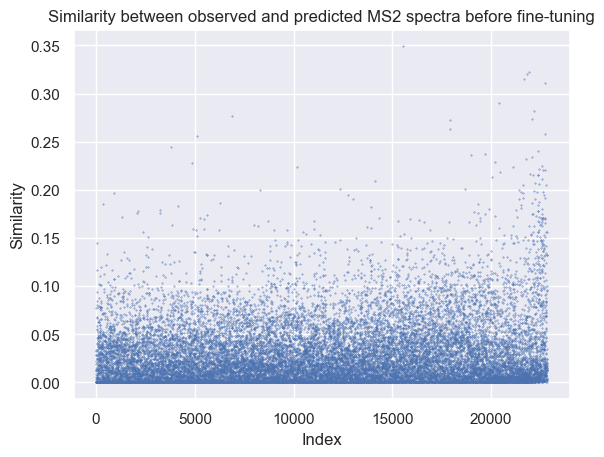

In [ ]:
res = tune_mgr.predict_all(transfer_lib.precursor_df.copy(), predict_items=['ms2'])

precursor_after_df = res['precursor_df']
fragment_mz_after_df = res['fragment_mz_df']
fragment_intensity_after_df = res['fragment_intensity_df']
similarity_after_df = calculate_similarity(precursor_after_df, transfer_lib.precursor_df, fragment_intensity_after_df, transfer_lib.fragment_intensity_df)
print(similarity_after_df['similarity'].median())
plt.scatter(similarity_after_df['index'], similarity_after_df['similarity'], s=0.1)
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.title('Similarity between observed and predicted MS2 spectra before fine-tuning')

In [45]:

# Testing the ms2 finetuning on the transfer library
ms2_stats = tune_mgr.finetune_ms2(psm_df=transfer_lib.precursor_df.copy(), matched_intensity_df=transfer_lib.fragment_intensity_df.copy())

100%|██████████| 2283/2283 [00:00<00:00, 2451.16it/s]


2024-12-30 23:49:10>  Model tested on validation dataset with the following metrics:
2024-12-30 23:49:10>  l1_loss                       : 0.1145
2024-12-30 23:49:10>  PCC-mean                      : -0.1060
2024-12-30 23:49:10>  COS-mean                      : 0.0171
2024-12-30 23:49:10>  SA-mean                       : 0.0109
2024-12-30 23:49:10>  SPC-mean                      : -1.0849
2024-12-30 23:49:10>  Fine-tuning MS2 model with the following settings:
2024-12-30 23:49:10>  Train fraction:      0.70     Train size:      15978     
2024-12-30 23:49:10>  Validation fraction: 0.20     Validation size: 4565      
2024-12-30 23:49:10>  Test fraction:       0.10     Test size:       2283      
2024-12-30 23:49:17>  Epoch 0   Lr: 0.00020   Training loss: 0.0795   validation loss: 0.1815
2024-12-30 23:49:31>  Epoch 3   Lr: 0.00050   Training loss: 0.0297   validation loss: 0.0689
2024-12-30 23:49:48>  Epoch 6   Lr: 0.00060   Training loss: 0.0189   validation loss: 0.0164
2024-12-30 23

### performance after fine tuning
We can see a huge improvement after we have done finetuning for the whole model and trained the last layer so we can predict more fragment types than the one used in the pretrained model.

2024-12-30 23:04:11> Predicting MS2 ...


100%|██████████| 36/36 [00:03<00:00, 11.96it/s]


Index(['b_z1', 'b_z2', 'y_z1', 'y_z2', 'c_z1', 'c_z2'], dtype='object')


C:\Users\USER\AppData\Local\Temp\ipykernel_26272\2151964994.py:22: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.dot(observed_intensity, predicted_intensity) / (np.linalg.norm(observed_intensity) * np.linalg.norm(predicted_intensity))


0.9875111856175615


Text(0.5, 1.0, 'Similarity between observed and predicted MS2 spectra after fine-tuning')

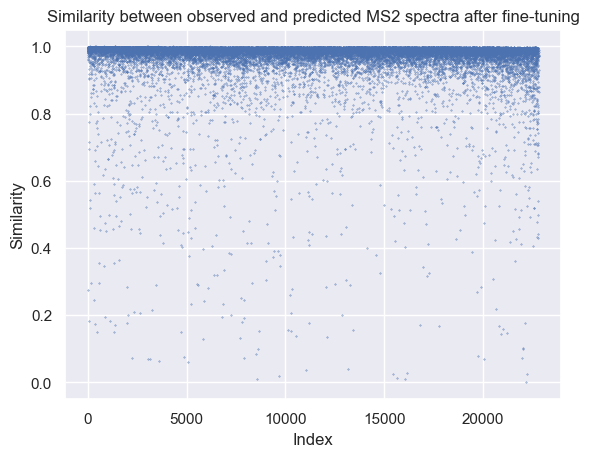

In [ ]:
res = tune_mgr.predict_all(transfer_lib.precursor_df.copy(), predict_items=["ms2"])

precursor_after_df = res["precursor_df"]
fragment_mz_after_df = res["fragment_mz_df"]
fragment_intensity_after_df = res["fragment_intensity_df"]
similarity_after_df = calculate_similarity(
    precursor_after_df,
    transfer_lib.precursor_df,
    fragment_intensity_after_df,
    transfer_lib.fragment_intensity_df,
)
print(similarity_after_df["similarity"].median())
plt.scatter(similarity_after_df["index"], similarity_after_df["similarity"], s=0.1)
plt.xlabel("Index")
plt.ylabel("Similarity")
plt.title("Similarity between observed and predicted MS2 spectra after fine-tuning")

In [ ]:
# save model to disk
path_to_save = "alphaDIA/transfer_weights"

tune_mgr.save_models(path_to_save)

### Loading the model for prediction

In [ ]:
from alphadia import libtransform, outputtransform
tune_mgr._normalize_intensity(transfer_lib.precursor_df, transfer_lib.fragment_intensity_df)
to_be_predicted = SpecLibBase()
to_be_predicted._precursor_df = transfer_lib.precursor_df.copy()
# ----------------- Verify that a warning is raised when using incorrect model -----------------
pept_deep_prediction = libtransform.PeptDeepPrediction(
                fragment_mz=[200,2000],
                fragment_types= ['b','y','c','a','x','z'],
                max_fragment_charge=2,
            )
pred = pept_deep_prediction.forward(to_be_predicted)
# calculate similarity
similarity_after_df = calculate_similarity(
    pred.precursor_df,
    transfer_lib.precursor_df,
    pred.fragment_intensity_df,
    transfer_lib.fragment_intensity_df,
)
print(f"Median similarity for the prediction: {similarity_after_df['similarity'].median()}")

2024-12-30 23:29:52> Device set to gpu
2024-12-30 23:29:54> The loaded weights are not strictly matched with the current model, some layers are still randomly initialized. Make sure to train the model or load different weights before prediction. The following keys had size mismatches: ['output_nn.nn.2.weight', 'output_nn.nn.2.bias'] The following keys were unexpected: ['modloss_nn.0.bert.layer.0.attention.self.query.weight', 'modloss_nn.0.bert.layer.0.attention.self.query.bias', 'modloss_nn.0.bert.layer.0.attention.self.key.weight', 'modloss_nn.0.bert.layer.0.attention.self.key.bias', 'modloss_nn.0.bert.layer.0.attention.self.value.weight', 'modloss_nn.0.bert.layer.0.attention.self.value.bias', 'modloss_nn.0.bert.layer.0.attention.output.dense.weight', 'modloss_nn.0.bert.layer.0.attention.output.dense.bias', 'modloss_nn.0.bert.layer.0.attention.output.LayerNorm.weight', 'modloss_nn.0.bert.layer.0.attention.output.LayerNorm.bias', 'modloss_nn.0.bert.layer.0.intermediate.dense.weight', '

100%|██████████| 36/36 [00:02<00:00, 12.65it/s]


2024-12-30 23:29:57> Predicting mobility ...


100%|██████████| 36/36 [00:02<00:00, 14.27it/s]


2024-12-30 23:30:00> Predicting MS2 ...


100%|██████████| 36/36 [00:03<00:00, 11.39it/s]

2024-12-30 23:30:03> Adding fragment mz information
2024-12-30 23:30:03> Adding fragment intensity information
2024-12-30 23:30:03> Adding precursor information


0.3532415056799123


In [ ]:
to_be_predicted = SpecLibBase()
to_be_predicted._precursor_df = transfer_lib.precursor_df.copy()
pept_deep_prediction = libtransform.PeptDeepPrediction(
                fragment_mz=[200,2000],
                fragment_types= ['b','y','c','a','x','z'],
                peptdeep_model_path=path_to_save,
                max_fragment_charge=2,
            )
pred = pept_deep_prediction.forward(to_be_predicted)
# calculate similarity
similarity_after_df = calculate_similarity(
    pred.precursor_df,
    transfer_lib.precursor_df,
    pred.fragment_intensity_df,
    transfer_lib.fragment_intensity_df,
)
print(f"Median similarity for the prediction: {similarity_after_df['similarity'].median()}")